In [1]:
using Revise
using TaD
using DifferentialEquations, Flux, DiffEqFlux
using Plots
using LinearAlgebra
using SparseArrays
import IJulia

┌ Info: Precompiling TaD [e673c115-fdda-452a-a923-4f686bacb4c9]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `TaD.BSplineBasis :: Union{}` in module `TaD`
└ @ Base.Docs docs/Docs.jl:240
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compil

# Reconstructing Helix in 3D

In [2]:
function create_ūk(Qk::Vector{<:Float64})
    """
    According to chord length method defined on pg 364
    """
    Qk_shift = copy(Qk)
    popfirst!(Qk_shift)
    pop!(Qk)
    ūk = cumsum(broadcast(abs, Qk_shift - Qk)) / sum(broadcast(abs, Qk_shift - Qk))
    if ((length(ūk) - length(Qk)) != 0)
        throw(AssertionError("Uk must be of length n-1"))
    end
    ūk
end

function create_knot_vector_really_good_version(Qk::Vector{<:Float64}, p::Integer = 3, n::Integer = length(Qk))
    ū = create_ūk(Qk)
    m = length(ū)
    kv = zeros(n + p + 2)
    d = (m + 1) / (n - p + 1)
    for j = 2:(n - p)
        i = floor(Int, j * d)
        α = j * d - i
        kv[j + p] = (1 - α) * ū[i - 1] + α * ū[i]
    end
    kv[(end - p):end] .= 1
    kv
end

function generate_helix_test_tangents(
    r::Real = 1,
    c::Real = 1,
    number_of_points::Integer = 100,
)
    t = LinRange(0, 100, number_of_points)
    dx = r .* cos.(t)
    dy = r .* sin.(t)
    dz = c
    arr = zeros(Float64, (length(t), 3))
    arr[:, 1] = dx
    arr[:, 2] = dy
    arr[:, 3] = c * t
    arr
end

generate_helix_test_tangents (generic function with 4 methods)

In [3]:
function WCLeastSquares(Qk::Vector{<:Float64}, Wq::Vector{<:Int64}, Dk::Vector{<:Float64}, Wd::Vector{<:Int64}, n::Int64, p::Integer = 3)
    """
    Weighted and Constrained Least Squares Curve Fit
    Qk: Points to be fit, Wq: Weights. Wq < 0 Means constrained point. Either 1 or -1
    Dk: Points to be fit, Wd: Weights. Wd < 0 Means constrained point. Either 1 or -1
    """
    mu = sum(Wq[Wq .> 0]) + sum(Wd[Wd .> 0])
    mc = abs(sum(Wq[Wq .< 0])) + abs(sum(Wd[Wd .< 0]))
    r = length(Qk)
    if (mc >= n || mc + n >= mu+1)
        throw(AssertionError("Too many constrained points, mc: $mc, n: $n, mu: $mu, \n"))
    end
    uk = create_ūk(Qk)
    kv = create_knot_vector_really_good_version(Qk)
    basis = BSplineBasis(kv, p, k=3)
    N, Nprime, M, Mprime = zeros(mu+1, n+1), zeros(mu+1, n+1), zeros(mc+1, n+1), zeros(mc+1, n+1)
    S, T = zeros(mu+1), zeros(mc+1)
    A = zeros(mc+1) #lagrange multipliers
    mu2, mc2 = 0, 0
    for i in 1:n
        if Wq[i] > 0 #Unconstrained
            mu2 += 1
            eval = uk[mu2]
            S[mu2] = Wq[i] * Qk[i]
            Nevals = basis(eval)
            N[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[1,:]
            Nprime[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[2,:]
        else
            mc2 += 1 #Constrained
            eval = uk[mc2]
            T[mc2] = Qk[i]
            Mevals = basis(uk[mc2])
            M[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[1,:]
            Mprime[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[2,:]

        end
        if i < length(Wd)
            if Wd[i] > 0 #Unconstrained
                mu2 += 1            
                eval = uk[mu2]
                S[mu2] = Wd[i] * Dk[i]
                Nevals = basis(uk[mu2])
                N[mu2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Nevals[2,:]
            else
                mc2 += 1 #Constrained
                eval = uk[mc2]
                T[mc2] = Dk[i]
                Mevals = basis(uk[mc2])
                M[mc2, (find_knot_span(basis, eval)-p+1):(find_knot_span(basis, eval)+1)] = Mevals[2,:]

            end
        end
    end
    if mc == 0
        P = inv(Nprime'*Nprime)*(Nprime'*S)
        return P
    end
    inverted = pinv(Nprime'*Nprime) #cant compute LU Decomposition, can't invert. 
    G = pinv(Mprime*inverted*Mprime')
    F = (Mprime*inverted*Nprime'*S - T)
    A = G*F
    P = pinv(N'*N)*((N'*S) - M'*A)
    return P, basis, kv, N, Nprime
end

WCLeastSquares (generic function with 2 methods)


 P1: (997,)
 Points: (997, 3)

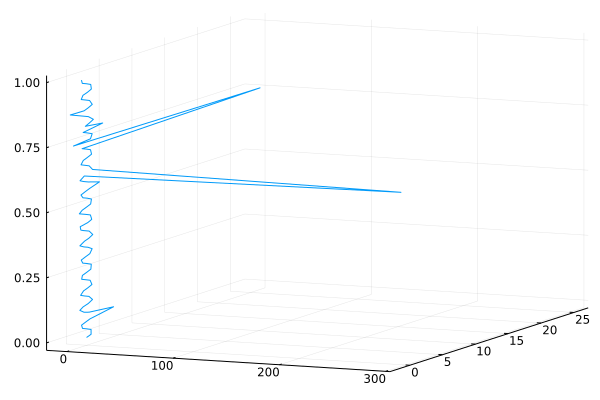

In [5]:
p = 3
Q = generate_helix_test_tangents(1, 1, 1000)
T = generate_helix_test_tangents(1, 1, 1000)
Wq = ones(Int64, length(Q[:,1]))
Wd = ones(Int64, 1).*-1
Wq[1] = -1
P1, basis, kv, N1, N1prime = WCLeastSquares(Q[:,1], Wq, T[:,1], Wd, Int(length(Q[:,1]) - 4), p)
P2, basis, kv, N2, N2prime = WCLeastSquares(Q[:,2], Wq, T[:,1], Wd, Int(length(Q[:,2])  - 4), p)
#P3 = WCLeastSquares(Q[:,3], Wq, T[:,3], Wd, Int(length(Q[:,3])/2))
print("\n P1: ", size(P1))
Points = hcat(P1, P2, collect((1. / length(P1)):(1. / length(P1)):1))
print("\n Points: ", size(Points))
basis = BSplineBasis(kv, 3, k=2)
Curve = BSplineCurve(basis, Points)
#print(Curve.control_points)
plot(N1*P1, N2*P2, collect(1:1:length(P1)+p))
#plot()
plot(Curve)

In [ ]:
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,1]
Uk = create_ūk(Q)
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,1]
print("Dims Uk, Dims Q: ", length(Uk)," ", length(Q), "\n")
kv = create_knot_vector_really_good_version(Q)
N = zeros(length(Uk), length(kv))
basis = BSplineBasis(kv, 3, k=3)
#print("kv: ", kv, "\n")
#print("Uk: ", Uk, "\n")
cnt = 0
for eval in Uk
    cnt=cnt+1
    evals = basis(eval)
    N[cnt, (find_knot_span(basis, eval)-2):(find_knot_span(basis, eval)+1)] = evals[2,:]
end
control_points = pinv(N'*N, rtol = sqrt(eps(real(float(one(eltype(N'*N)))))))*N'*Q
print("DIms: ", size(control_points), size(control_points), size(collect(0:.001:1.002)))
cps = hcat(control_points, control_points, collect(0:.001:1.002))

Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,2]
Uk = create_ūk(Q)
Q = generate_helix_test_tangents(1, 1, 1000)
Q = Q[:,2]
print("Dims Uk, Dims Q: ", length(Uk)," ", length(Q), "\n")
kv = create_knot_vector_really_good_version(Q)
N = zeros(length(Uk), length(kv))
basis = BSplineBasis(kv, 3, k=3)
#print("kv: ", kv, "\n")
#print("Uk: ", Uk, "\n")
cnt = 0
for eval in Uk
    cnt=cnt+1
    evals = basis(eval)
    N[cnt, (find_knot_span(basis, eval)-2):(find_knot_span(basis, eval)+1)] = evals[2,:]
end
control_points = pinv(N'*N, rtol = sqrt(eps(real(float(one(eltype(N'*N)))))))*N'*Q
cps[:,2] = control_points
#print("Control Points: ", cps)
Curve = BSplineCurve(basis, cps)
#print("Dims N*cps, cps[:,3]: ", size(N*cps[:,1]), size(cps[:,3]))
#tangents = [N*cps[:,1] N*cps[:,2] cps[:,3]]
#print(size(tangents))
Q = generate_helix_test_tangents(1, 1, 1000)
Q1 = copy(Q[:,1])
pop!(Q1)
print(size(Q1))
#plot((tangents[:,1],tangents[:,2], tangents[:,3]))
plot(Curve, k=0)